# Example Solution - A03
## SIS Model

In [4]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random as rnd

### Task 3.1
SIR Model in well-mixed population.

In [83]:
def gillespie_wellmixed(N,gamma,initial_infectionrate,r):
    
    # creating 20 values between 0 and 0.3
    betas = np.linspace(0,0.3,20)
    
    avg_fraction_per_beta = []
    
    for beta in betas:
        R_per_run = []  

        for i in range (0,r):
            S_Init = np.zeros(int(N-N*initial_infectionrate),dtype=int)
            I_Init = np.ones(int(N*initial_infectionrate),dtype=int)
            populationvector = np.append(S_Init,I_Init)
            np.random.shuffle(populationvector)
            time = 0

            while np.sum( populationvector == 1 ) > 0:
                # calculating aggregated infection and recovery rates
                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * gamma
                total_rate = infection_rate + total_recovery_rate
                next_event = -np.log(rnd.random()) / total_rate
                time += next_event

                if rnd.random() < (infection_rate / total_rate):
                    # infection takes place
                    index_S = np.where(populationvector == 0)
                    populationvector[index_S[0][0]] = 1

                else:
                    # recovery takes place
                    index_infected = np.where(populationvector == 1) 
                    populationvector[index_infected[0][0]] = 2            

                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * gamma
                total_rate = infection_rate + total_recovery_rate


            S= np.sum( populationvector == 0 )
            I= np.sum( populationvector == 1 )
            R= np.sum( populationvector == 2 )
            #print(time,S,I,R)
            R_per_run.append(R)
            
        avg_fraction_per_beta.append(np.mean(R_per_run)/N)
        
    #print(avg_fraction_per_beta)
    
    plt.plot(betas, avg_fraction_per_beta)   
    plt.title('Final Fraction of Recovered Agents')
    plt.xlabel("Beta (Infection Rate)")
    plt.ylabel("Fraction of Recovered Agents")
    plt.show()     

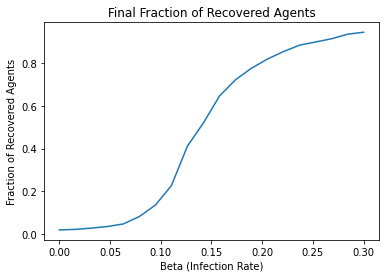

In [84]:
gillespie_wellmixed(1000,0.1,0.02,20)

### As can be derived from the plot, a phase transition occurs at around Beta = 0.10, as the R0-value (Beta/Gamma) is larger than 1 from there on.

### Task 3.2
SIR Model on Barabasi-Albert Network with m=2.

In [91]:
def gillespie_network_BA(gamma,initial_infectionrate,r):
    
    betas = np.linspace(0,0.3,20)
    
    # Defining the Ns and iterating for them
    Ns = [50,100,500,1000]
    
    for N in Ns: 
        avg_fraction_per_beta = []

        for beta in betas:
            R_per_run = []  

            for i in range (0,r):
                # Creating the BA-Network with m=2
                G = nx.barabasi_albert_graph(N,2)

                S_Init = np.zeros(int(N-N*initial_infectionrate),dtype=int)
                I_Init = np.ones(int(N*initial_infectionrate),dtype=int)
                populationvector = np.append(S_Init,I_Init)
                
                # Random shuffle of populatiol vector, to ensure that initially infected nodes are randomly selected
                np.random.shuffle(populationvector)
                time = 0

                while np.sum( populationvector == 1 ) > 0:
                    # Calculating the sum of active links per node
                    active_links = np.zeros(N,dtype=int)
                    for node in G.nodes():
                        if populationvector[node] == 0:
                            for neighbor in G.neighbors(node):
                                if populationvector[neighbor] == 1:
                                    active_links[node] += 1
                    # Calculating aggregated infection and recovery rates
                    infection_rate = np.sum(active_links) * beta                
                    total_recovery_rate = ((np.sum( populationvector == 1 ))) * gamma
                    total_rate = infection_rate + total_recovery_rate
                    next_event = -np.log(rnd.random()) / total_rate
                    time += next_event

                    if rnd.random() < (infection_rate / total_rate):
                        S_Node, = np.where( populationvector == 0 )
                        weights = active_links[S_Node].astype(np.float64)
                        infected_node = np.random.choice( S_Node, p = weights/np.sum(weights))
                        populationvector[[infected_node][0]] = 1

                    else:
                        I_Node, = np.where ( populationvector == 1 )
                        recover_node = rnd.choice( I_Node )
                        populationvector[[recover_node][0]] = 2            

                    infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                    total_recovery_rate = ((np.sum( populationvector == 1 ))) * gamma
                    total_rate = infection_rate + total_recovery_rate


                S= np.sum( populationvector == 0 )
                I= np.sum( populationvector == 1 )
                R= np.sum( populationvector == 2 )
                R_per_run.append(R)

            avg_fraction_per_beta.append(np.mean(R_per_run)/N)
        
        #print(avg_fraction_per_beta)
        #print(time,S,I,R)
        plt.plot(betas, avg_fraction_per_beta, label='N={}, Avg Recovered Fraction={:.3f}' .format(N,np.mean(avg_fraction_per_beta)))   
    plt.title('Final Fraction of Recovered Agents')
    plt.xlabel("Beta (Infection Rate)")
    plt.ylabel("Fraction of Recovered Agents")
    plt.legend()

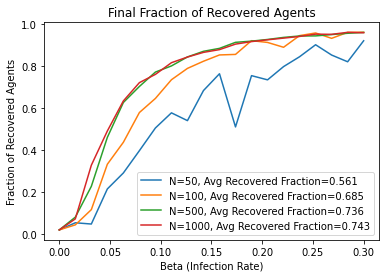

In [92]:
gillespie_network_BA(0.1,0.02,20)

### The Barabasi-Albert Network is a scale-free network, therefore there is no epidemic threshold, as R. Pastor-Satorras & A. Vespignani (2001) pointed out. The consequence is that no transition phase can be identified on the plot above, and that even for very small values of Beta a large fraction of the population gets infected / recovered, which is especially obvious for large populations (large N). The spread of infection for the Barabasi-Albert Network is faster than for the well-mixed population, as there are several central hubs with a large number of active links that could be especially infectious once they are infected.

### Task 3.3
SIR Model in well-mixed population with lockdown at t=10.

In [86]:
def gillespie_wellmixed_lockdown(N,gamma,initial_infectionrate,runs,lockdown):
    
    betas = np.linspace(0,0.3,20)

    avg_fraction_per_beta = []
    
    for beta in betas:
        R_per_run = []  

        for i in range (0,runs):
            S_Init = np.zeros(int(N-N*initial_infectionrate),dtype=int)
            I_Init = np.ones(int(N*initial_infectionrate),dtype=int)
            populationvector = np.append(S_Init,I_Init)
            time = 0
            # Lockdown Switch to ensure Lockdown only happens "once"
            lockdownswitch = 0

            while np.sum( populationvector == 1 ) > 0:
                
                if time >= lockdown and lockdownswitch == 0:
                    # Lockdown takes palce when time >= 10 (specified as lockdown)
                    beta = beta/10
                    lockdownswitch = 1
                    
                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * gamma
                total_rate = infection_rate + total_recovery_rate
                
                next_event = -np.log(rnd.random()) / total_rate
                time += next_event
                
                if rnd.random() < (infection_rate / total_rate):
                    index_S = np.where(populationvector == 0)
                    populationvector[index_S[0][0]] = 1

                else:
                    index_infected = np.where(populationvector == 1) 
                    populationvector[index_infected[0][0]] = 2            

                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * gamma
                total_rate = infection_rate + total_recovery_rate


            S= np.sum( populationvector == 0 )
            I= np.sum( populationvector == 1 )
            R= np.sum( populationvector == 2 )
            #print(time,S,I,R)
            R_per_run.append(R)
            
        avg_fraction_per_beta.append(np.mean(R_per_run)/N)
    
    plt.plot(betas, avg_fraction_per_beta)   
    plt.title('Final Fraction of Recovered Agents')
    plt.xlabel("Beta (Initial Infection Rate before Lockdown at t={})".format(lockdown))
    plt.ylabel("Fraction of Recovered Agents")

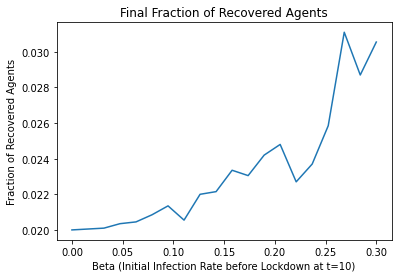

In [90]:
gillespie_wellmixed_lockdown(1000,0.1,0.02,20,10)